# Generate plot showing the efect of moment delta mapping on the quantifle function at individual location and day of year.
- PI= Pre-industrial, EOC= End-of-21st-century
- MDM - moment delta mapping
- QDM - Quantile delta mapping

## Section 1: Load functions and start a cluster

In [86]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
# import xskillscore as xs
import cartopy as cart
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numbers
from scipy.special import erfinv, erf
import xskillscore as xs
from datetime import datetime, timedelta
from matplotlib.legend_handler import HandlerLine2D

In [87]:
%config InlineBackend.figure_format = 'retina'

In [88]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [89]:
def gauss_quantile(mean,std,quantile):
    #quantile must be a real number neteoceen 0 and 1
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue

In [90]:
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
#SGP
sgp_lat   = 36.605
sgp_lon   = (360-97.485)%360
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
rda_scratch = '/glade/campaign/collections/rda/scratch/harshah'
rda_url     =  'https://data.rda.ucar.edu/'
rda_data    = '/glade/campaign/collections/rda/data/harshah/'
#
tmean_path  = rda_data + 'mdm_data/tmean/'
tmax_path   = rda_data + 'mdm_data/tmax/'
tmin_path   = rda_data + 'mdm_data/tmin/'
############
pi_year  = 1865
eoc_year = 2085
#
doy  = 211
#
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'

In [91]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [92]:
def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_shift(ds_obs,init_mean,final_mean):
    # Assuming coordinates year and day for ds_obs
    #obs_mean   = ds_obs.mean('year')
    ds_shift   = ds_obs + (final_mean - init_mean) 
    return ds_shift 
    
def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

#
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

In [93]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B%d')
###############################
date = no_leap_date(doy)
date

'July30'

In [94]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk25-mdm',
    cores = 1,
    memory = '16GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=16GB',
    queue = 'casper',
    walltime = '5:00:00',
    interface = 'ext'
)

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42635 instead
  warnings.warn(


In [95]:
# Create the client to load the Dashboard
client = Client(cluster)

In [96]:
n_workers = 8
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(629e1954, 'tcp://128.117.208.95:44983', workers=8, threads=8, memory=128.00 GiB)

In [97]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################

def altspace(start, step, count, endpoint=False, **kwargs):
   stop = start+(step*count)
   return np.linspace(start, stop, count, endpoint=endpoint, **kwargs)

## Section 2: Load Data 

In [98]:
var_name    = 'tmax'
folder_path = tmax_path
det_var     = 'detrended_tmax'
temp_var    = 'TREFHTMX'

In [99]:
pi_detrended  = xr.open_zarr(folder_path + f'pre_ind_detrended_{var_name}.zarr')
eoc_detrended = xr.open_zarr(folder_path + f'eoc_detrended_{var_name}.zarr')
#
pi_detrended = pi_detrended[det_var]
eoc_detrended = eoc_detrended[det_var]
pi_detrended

<xarray.DataArray 'detrended_tmax' (member_id: 100, lat: 192, lon: 288,
                                    year: 30, dayofyear: 365)> Size: 484GB
dask.array<open_dataset-detrended_tmax, shape=(100, 192, 288, 30, 365), dtype=float64, chunksize=(1, 48, 288, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
    degree     int64 8B ...
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * year       (year) int64 240B 1850 1851 1852 1853 ... 1876 1877 1878 1879

In [100]:
member_ids = pi_detrended['member_id']
# member_ids

In [101]:
pi_sgp   = pi_detrended.sel(lat=sgp_lat,lon=sgp_lon,method='nearest').sel(dayofyear=doy)
eoc_sgp  = eoc_detrended.sel(lat=sgp_lat,lon=sgp_lon,method='nearest').sel(dayofyear=doy)      
# pi_sgp

In [102]:
pi_sgp_mean  = pi_sgp.mean('year')
eoc_sgp_mean = eoc_sgp.mean('year')
pi_sgp_std   = pi_sgp.std('year')
eoc_sgp_std  = eoc_sgp.std('year')

## Section 3: Implement MDM and QDM

In [103]:
sgp_mdm = implement_mdm(pi_sgp,pi_sgp_mean,eoc_sgp_mean,pi_sgp_std,eoc_sgp_std)
# sgp_mdm

In [104]:
sgp_shift = implement_shift(pi_sgp,pi_sgp_mean,eoc_sgp_mean)
# sgp_shift 

In [105]:
qsgp_mdm   = compute_quantiles(sgp_mdm)
qsgp_shift = compute_quantiles(sgp_shift)
qsgp_eoc   = compute_quantiles(eoc_sgp)
qsgp_pi    = compute_quantiles(pi_sgp)

In [106]:
# Compute QDM
qsgp_qdm = implement_qdm(qsgp_pi, qsgp_pi, qsgp_eoc)
qsgp_qdm

<xarray.DataArray 'detrended_tmax' (quantile: 30, member_id: 100)> Size: 24kB
dask.array<add, shape=(30, 100), dtype=float64, chunksize=(30, 1), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

CPU times: user 382 ms, sys: 9.11 ms, total: 391 ms
Wall time: 2.69 s


Text(0.5, 1.03, 'July30 at SGP')

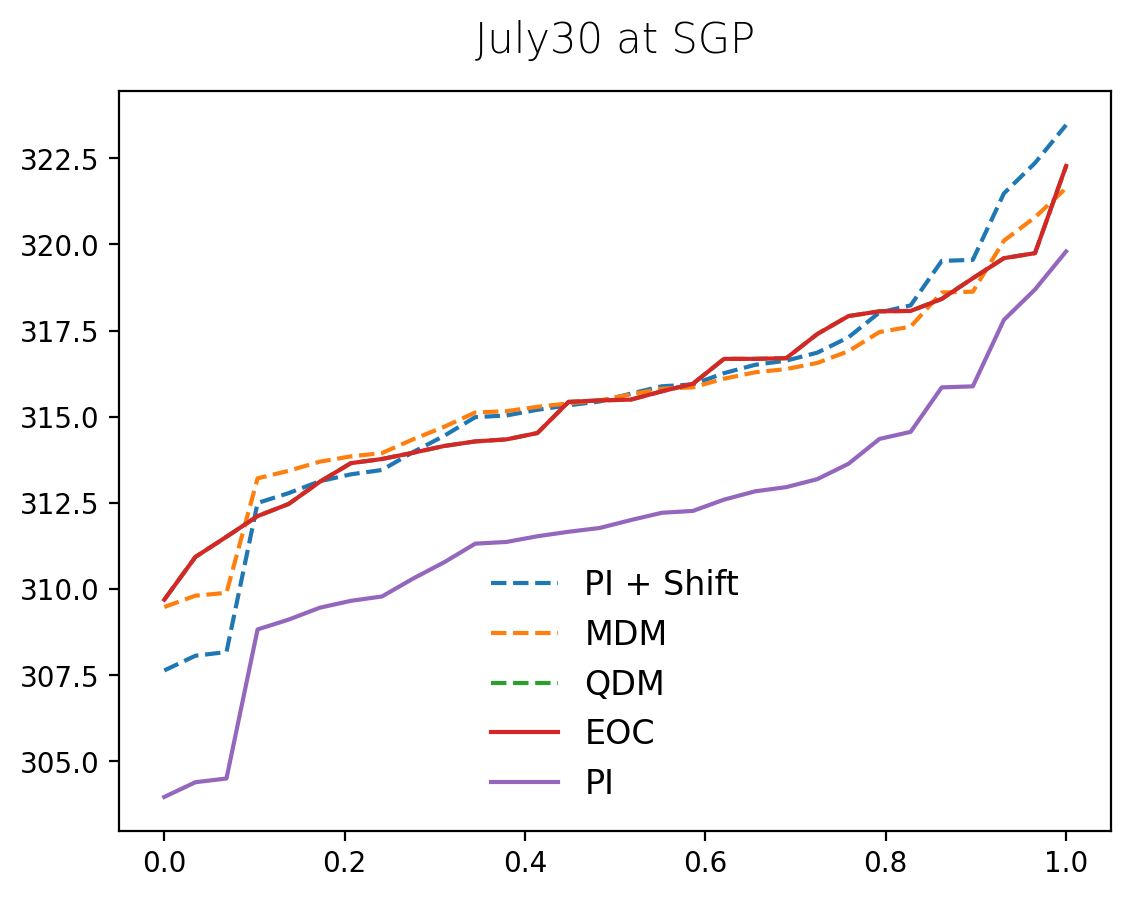

In [107]:
%%time
member_id = member_ids[0]
plt.plot(quants,qsgp_shift.sel(member_id=member_id),'--',label='PI + Shift')
plt.plot(quants,qsgp_mdm.sel(member_id=member_id),'--',label='MDM')
plt.plot(quants,qsgp_qdm.sel(member_id=member_id),'--',label='QDM')
#
plt.plot(quants,qsgp_eoc.sel(member_id=member_id),label='EOC')
plt.plot(quants,qsgp_pi.sel(member_id=member_id),label='PI')
plt.legend(loc='lower center',prop={'size': 12},frameon=False)
plt.title(date + ' at SGP',fontweight=200,fontsize=15, y=1.03)

#### Compute Ensemble Mean (emean)

In [108]:
qsgp_mdm_emean    = qsgp_mdm.mean('member_id')
qsgp_shift_emean  = qsgp_shift.mean('member_id')
#
qsgp_eoc_emean = qsgp_eoc.mean('member_id')
qsgp_pi_emean  = qsgp_pi.mean('member_id')
qsgp_pi_emean 

<xarray.DataArray 'detrended_tmax' (quantile: 30)> Size: 240B
dask.array<mean_agg-aggregate, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [109]:
# %%time
# qsgp_mdm_emean.rename(var_name).to_dataset().to_zarr(folder_path +'qsgp_mdm_emean.zarr',mode='w')
# qsgp_shift_emean.rename(var_name).to_dataset().to_zarr(folder_path +'qsgp_shift_emean.zarr',mode='w')

In [110]:
# %%time
# qsgp_eoc_emean.rename(var_name).to_dataset().to_zarr(folder_path +'qsgp_eoc_emean.zarr',mode='w')
# qsgp_pi_emean.rename(var_name).to_dataset().to_zarr(folder_path +'qsgp_pi_emean.zarr',mode='w')

In [111]:
qsgp_mdm_emean   = xr.open_zarr(folder_path +'qsgp_mdm_emean.zarr')
qsgp_shift_emean = xr.open_zarr(folder_path +'qsgp_shift_emean.zarr')
qsgp_eoc_emean   = xr.open_zarr(folder_path +'qsgp_eoc_emean.zarr')
qsgp_pi_emean    = xr.open_zarr(folder_path +'qsgp_pi_emean.zarr')
#
qsgp_mdm_emean   = qsgp_mdm_emean[var_name]
qsgp_shift_emean = qsgp_shift_emean[var_name]
qsgp_eoc_emean   = qsgp_eoc_emean[var_name]
qsgp_pi_emean    = qsgp_pi_emean[var_name]
qsgp_pi_emean

<xarray.DataArray 'tmax' (quantile: 30)> Size: 240B
dask.array<open_dataset-tmax, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

CPU times: user 91 ms, sys: 22 μs, total: 91 ms
Wall time: 533 ms


[]

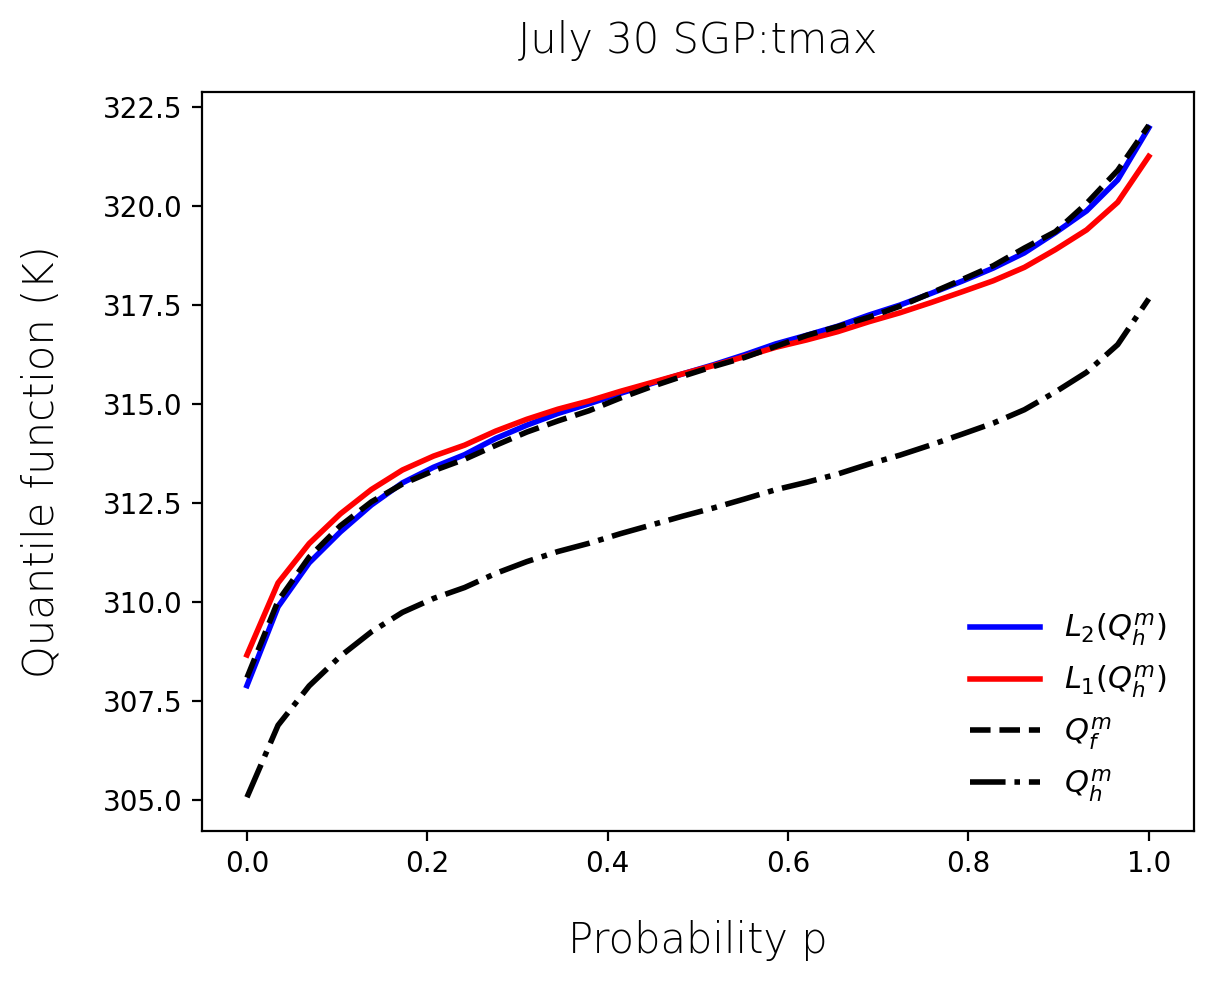

In [112]:
%%time
plt.plot(quants,qsgp_mdm_emean,color='blue',label=r'$L_2(Q_h^m)$',lw=2)
plt.plot(quants,qsgp_shift_emean,color='red',label=r'$L_1(Q_h^m)$',lw=2)
plt.plot(quants,qsgp_eoc_emean,'k--',label=r'$Q_f^m$',lw=2)
plt.plot(quants,qsgp_pi_emean,'-.',color='k',label= r'$Q_h^m$',lw=2)
plt.legend(loc='lower right',prop={'size': 11},frameon=False,handlelength=2.29)
plt.title('July 30 SGP:'+ var_name,fontweight=200,fontsize=15, y=1.03)
plt.ylabel('Quantile function (K)',fontweight=200,fontsize=15,labelpad=15)
plt.xlabel('Probability p',fontweight=200,fontsize=15,labelpad=15)
plt.plot()

### Global MDM error

In [113]:
pi_day  = pi_detrended.sel(dayofyear=doy)
eoc_day = eoc_detrended.sel(dayofyear=doy)  

In [114]:
pi_day_mean  = pi_day.mean('year')
eoc_day_mean = eoc_day.mean('year')
pi_day_std   = pi_day.std('year')
eoc_day_std  = eoc_day.std('year')

In [115]:
mdm_day = implement_mdm(pi_day,pi_day_mean,eoc_day_mean,pi_day_std,eoc_day_std)
# mdm_day

In [116]:
shift_day = implement_shift(pi_day,pi_day_mean,eoc_day_mean)

In [117]:
qmdm_day   = compute_quantiles(mdm_day)
qeoc_day   = compute_quantiles(eoc_day)
qshift_day = compute_quantiles(shift_day)
qpi_day    = compute_quantiles(pi_day)
qmdm_day 

<xarray.DataArray 'detrended_tmax' (quantile: 30, member_id: 100, lat: 192,
                                    lon: 288)> Size: 1GB
dask.array<transpose, shape=(30, 100, 192, 288), dtype=float64, chunksize=(30, 1, 48, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [118]:
print(folder_path +'qmdm_'+date+'.zarr')

/glade/campaign/collections/rda/data/harshah/mdm_data/tmax/qmdm_July30.zarr


In [119]:
# %%time
# qmdm_day.rename(var_name).to_dataset().to_zarr(folder_path +'qmdm_'+date+'.zarr',mode='w')
# qshift_day.rename(var_name).to_dataset().to_zarr(folder_path +'qshift_'+date+'.zarr',mode='w')
# qeoc_day.rename(var_name).to_dataset().to_zarr(folder_path +'qeoc_'+date+'.zarr',mode='w')
# qpi_day.rename(var_name).to_dataset().to_zarr(folder_path +'qpi_'+date+'.zarr',mode='w')

In [120]:
qmdm_day   = xr.open_zarr(folder_path +'qmdm_'+date+'.zarr')
qeoc_day   = xr.open_zarr(folder_path +'qeoc_'+date+'.zarr')
qpi_day    = xr.open_zarr(folder_path +'qpi_'+date+'.zarr')
qshift_day = xr.open_zarr(folder_path +'qshift_'+date+'.zarr')
#
qmdm_day   = qmdm_day[var_name]
qeoc_day   = qeoc_day[var_name]
qpi_day    = qpi_day[var_name]
qshift_day = qshift_day[var_name]
qmdm_day 

<xarray.DataArray 'tmax' (quantile: 30, member_id: 100, lat: 192, lon: 288)> Size: 1GB
dask.array<open_dataset-tmax, shape=(30, 100, 192, 288), dtype=float64, chunksize=(30, 1, 48, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [121]:
qmdm_err           = qmdm_day - qeoc_day
qshift_err         = qshift_day - qeoc_day
qmdm_abs_err       = np.abs(qmdm_day - qeoc_day)
qshift_abs_err     = np.abs(qshift_day - qeoc_day)
qmdm_emean_abs_err = qmdm_abs_err.mean('member_id')

In [122]:
# ######## New colorbar only for shift + stretch and gaussian ############
# x = 3.5
# # create a figure and axis
# fig, ax = plt.subplots(figsize=(6, 1))
# fig.subplots_adjust(bottom=0.5)
# # Define colormap
# cmap = plt.get_cmap('RdBu_r')
# # Make a norm object with the center at 0: TwoSlopeNorm
# norm = mcolors.TwoSlopeNorm(vmin=-x, vcenter=0, vmax=x)
# # Making numpy array from -3 to 3, with step 0.2
# values = np.arange(-x, x+0.25, 0.25)
# # Creating a mappable object and setting the norm and cmap for colorbar
# mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
# mappable.set_array([])
# # Creating a colorbar
# ticks1 = altspace(-4,1,9)
# cbar = plt.colorbar(mappable, ax=ax, orientation='vertical',ticks=ticks1)
# cbar.set_label('')
# plt.gca().set_visible(False)

CPU times: user 1.24 s, sys: 31.8 ms, total: 1.28 s
Wall time: 7.3 s


Text(0.5, 1.0, 'tmax,July 30: $L_2(Q^m_h) − Q^m_f$ at $p = 0.9$')

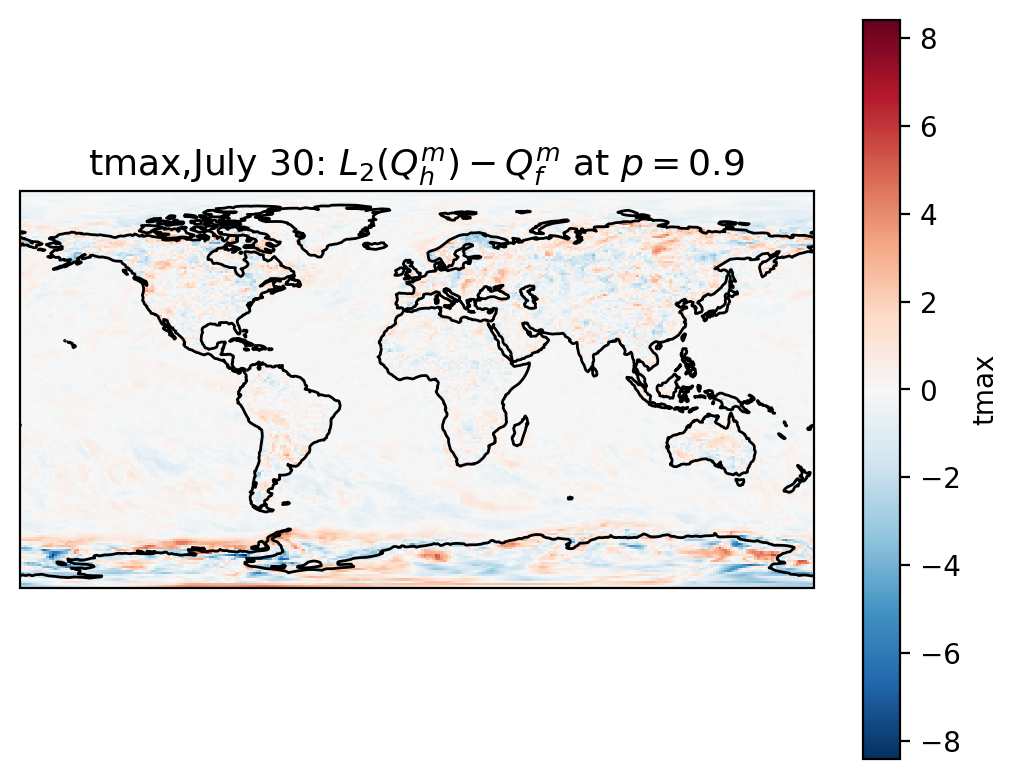

In [123]:
%%time
ax            = plt.axes(projection=cart.crs.PlateCarree())
im = qmdm_err.sel(quantile=0.9,method='nearest').isel(member_id=0).plot(ax=ax,transform=cart.crs.PlateCarree()
                                      )
ax.coastlines(color="black")
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(var_name+ r',July 30: $L_2(Q^m_h) − Q^m_f$ at $p = 0.9$',fontsize=13)

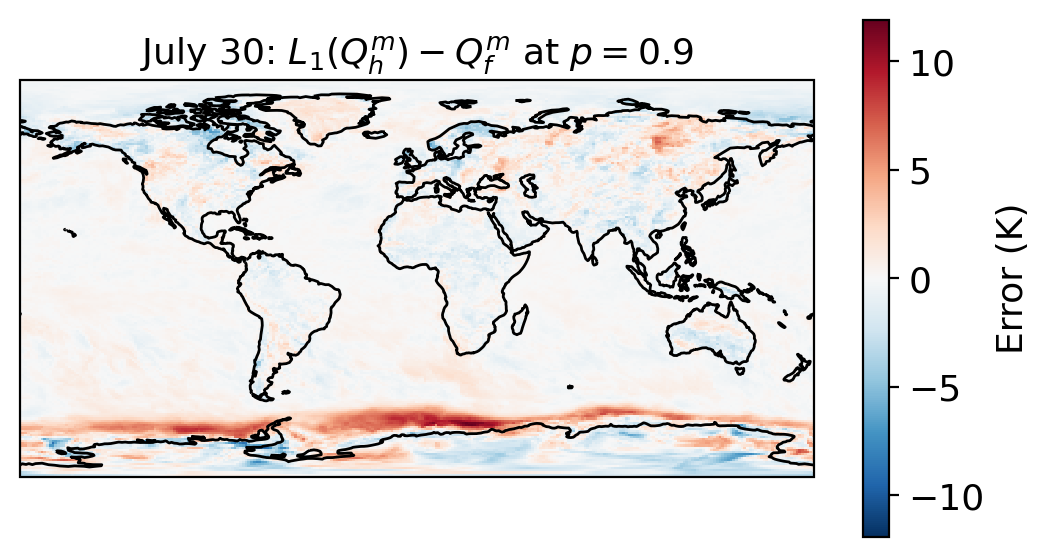

CPU times: user 719 ms, sys: 8.2 ms, total: 727 ms
Wall time: 907 ms


In [124]:
%%time
ax            = plt.axes(projection=cart.crs.PlateCarree())
im = qshift_err.sel(quantile=0.9,method='nearest').isel(member_id=0).plot(ax=ax,transform=cart.crs.PlateCarree()
                                      ,add_colorbar=False)
ax.coastlines(color="black")
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(r'July 30: $L_1(Q^m_h) − Q^m_f$ at $p = 0.9$',fontsize=13)
#
# Adding colorbar
cbar = plt.colorbar(im,ax=ax, shrink=0.7, orientation='vertical')
cbar.set_label('Error (K)',fontsize=13)
cbar.ax.tick_params(labelsize=13) 
plt.show()

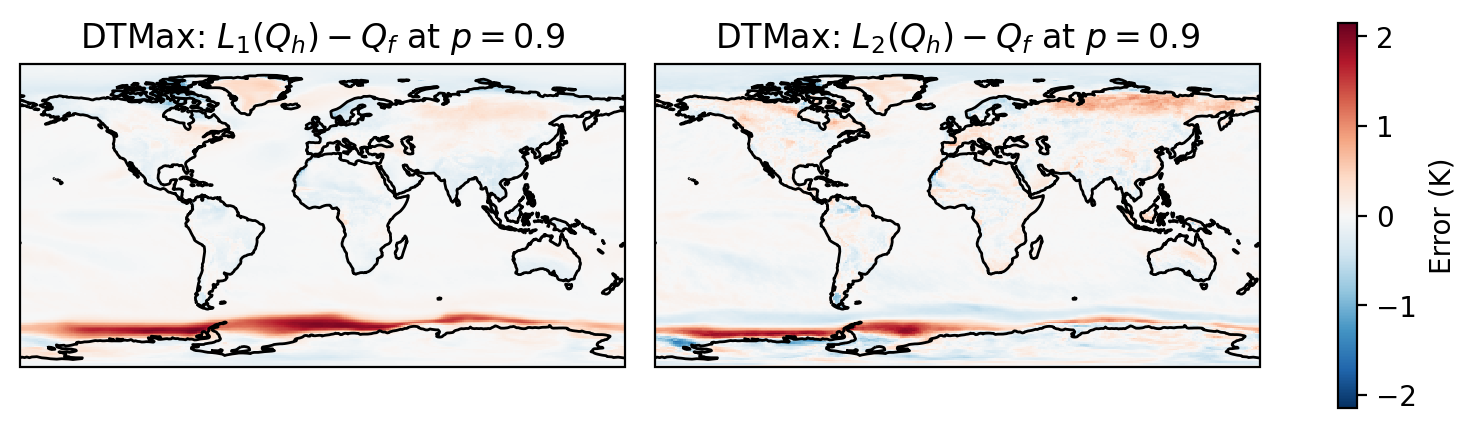

CPU times: user 3.72 s, sys: 147 ms, total: 3.86 s
Wall time: 12 s


In [125]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), subplot_kw={'projection': cart.crs.PlateCarree()}\
                       , gridspec_kw = {'wspace':0.05, 'hspace':0.2})

# Plotting L1 error
qshift_err.sel(quantile=0.9,method='nearest').mean('member_id').plot(ax=axs[0], transform=cart.crs.PlateCarree(),\
                                                    add_colorbar=False)
axs[0].coastlines(color="black")
axs[0].set_title('DTMax' + r': $L_1(Q_h) - Q_f$ at $p=0.9$')

# Plotting L2 error
im = qmdm_err.sel(quantile=0.9,method='nearest').mean('member_id').plot(ax=axs[1], transform=cart.crs.PlateCarree(),\
                                                          add_colorbar=False)
axs[1].coastlines(color="black")
axs[1].set_title('DTMax' + r': $L_2(Q_h) - Q_f$ at $p=0.9$')

# Adding colorbar
cbar = plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5, orientation='vertical',)
cbar.set_label('Error (K)')

plt.show()

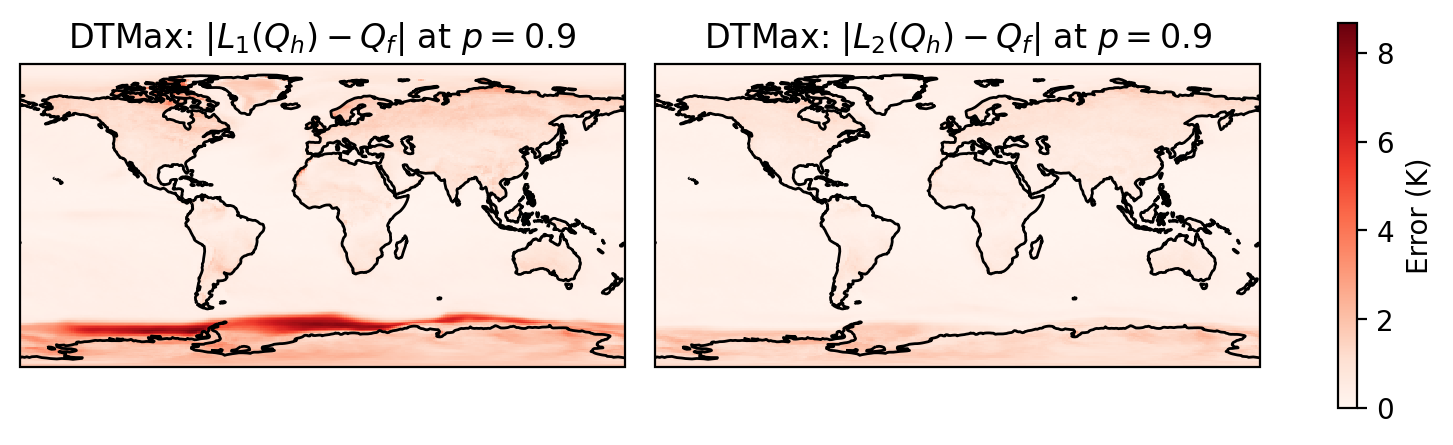

CPU times: user 7.02 s, sys: 221 ms, total: 7.25 s
Wall time: 16 s


In [126]:
%%time
import matplotlib.colors as mcolors

# Extract and compute data slices
q1 = qshift_abs_err.sel(quantile=0.9, method='nearest').mean('member_id')
q2 = qmdm_abs_err.sel(quantile=0.9, method='nearest').mean('member_id')

# Determine global vmin and vmax (we want a common color scale starting at 0)
vmin = 0
vmax = max(q1.max().values, q2.max().values)  # .item() converts 0d xarray to Python float

# Define normalization and colormap
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.Reds

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5),
                        subplot_kw={'projection': cart.crs.PlateCarree()},
                        gridspec_kw={'wspace': 0.05, 'hspace': 0.2})

# Plotting L1 error
q1.plot(ax=axs[0], transform=cart.crs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
axs[0].coastlines(color="black")
axs[0].set_title('DTMax' + r': $|L_1(Q_h) - Q_f|$ at $p=0.9$')

# Plotting L2 error
im = q2.plot(ax=axs[1], transform=cart.crs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
axs[1].coastlines(color="black")
axs[1].set_title('DTMax' + r': $|L_2(Q_h) - Q_f|$ at $p=0.9$')

# Colorbar
cbar = plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5, orientation='vertical')
cbar.set_label('Error (K)')

plt.show()


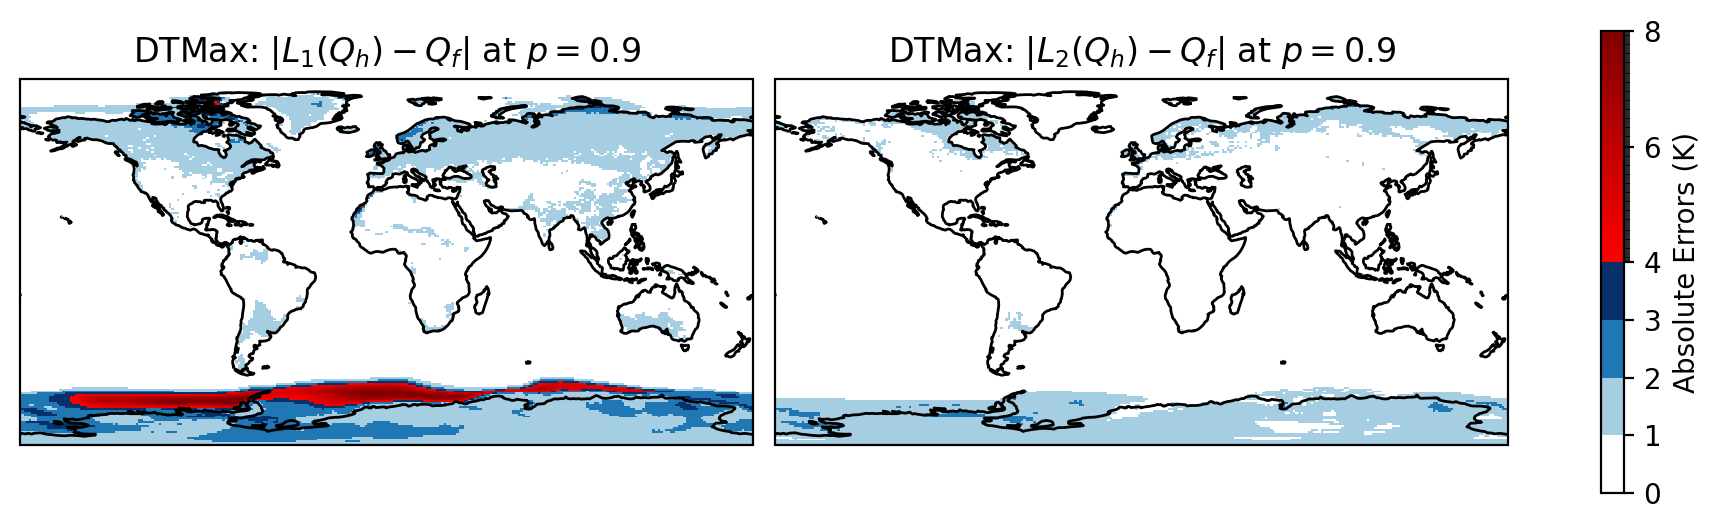

In [132]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import cartopy.crs as ccrs

# 1. Compute your p=0.9 mean‐error fields
q1 = qshift_abs_err.sel(quantile=0.9, method='nearest').mean('member_id')
q2 = qmdm_abs_err.sel(quantile=0.9, method='nearest').mean('member_id')

# 2. Define bins: 0–1,1–2,2–3,3–4 flat; 4–8 subdivided finely
n_red = 128
bounds = [0, 1, 2, 3, 4] + list(np.linspace(4, 8, n_red + 1)[1:])

# 3. Flat white/blues for 0–4 K
flat_colors = ["white", "#a6cee3", "#1f78b4", "#08306b"]

# 4. Pure‐red ramp from R=1→0.5, G,B=0
red_ramp = np.vstack([
    np.linspace(1.0, 0.5, n_red),  # R
    np.zeros(n_red),               # G
    np.zeros(n_red),               # B
    np.ones(n_red)                 # A
]).T

# 5. Build colormap & norm
colors = flat_colors + list(red_ramp)
cmap   = ListedColormap(colors)
norm   = BoundaryNorm(bounds, ncolors=len(colors), clip=True)

# 6. Plot side by side
fig, axs = plt.subplots(
    1, 2, figsize=(12, 5),
    subplot_kw={'projection': ccrs.PlateCarree()},
    gridspec_kw={'wspace': 0.03}
)

titles = [
    'DTMax: $|L_1(Q_h)-Q_f|$ at $p=0.9$',
    'DTMax: $|L_2(Q_h)-Q_f|$ at $p=0.9$'
]

for ax, data, title in zip(axs, (q1, q2), titles):
    im = ax.pcolormesh(
        data.lon, data.lat, data,
        transform=ccrs.PlateCarree(),
        cmap=cmap, norm=norm
    )
    ax.coastlines()
    ax.set_title(title)

# 7. Shared colorbar
cbar = fig.colorbar(
    im, ax=axs,
    boundaries=bounds,
    spacing='proportional',
    ticks=[0, 1, 2, 3, 4, 6, 8],
    shrink=0.6,
    orientation='vertical'
)
cbar.set_label('Absolute Errors (K)')

# Turn off the thin black edges between colorbar segments:
cbar.solids.set_edgecolor('face')
cbar.solids.set_linewidth(0)
#cbar.solids.set_antialiased(False)

#cbar.outline.set_visible(False)
plt.savefig("fig3.pdf", format="pdf", bbox_inches="tight",dpi=600)
plt.show()

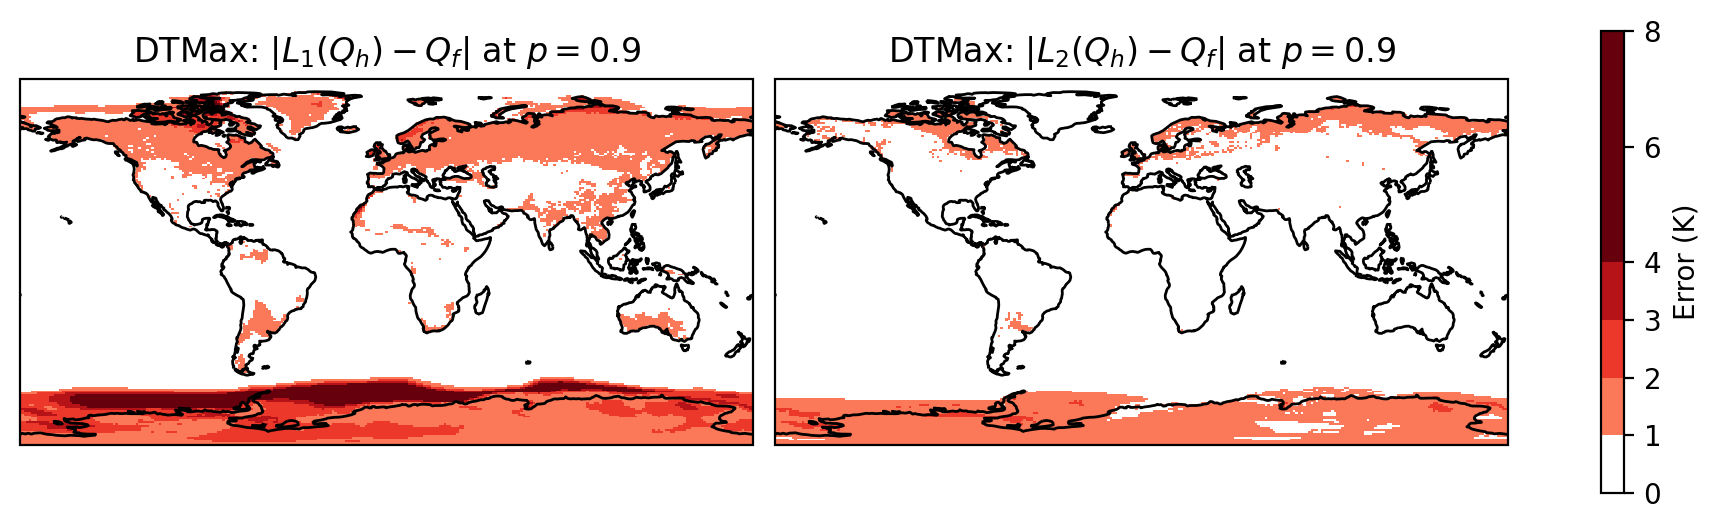

In [128]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np

# 1. Compute your error fields at p=0.9
q1 = qshift_abs_err.sel(quantile=0.9, method='nearest').mean('member_id')
q2 = qmdm_abs_err.sel(quantile=0.9, method='nearest').mean('member_id')

# 2. Define bin edges and create colors
bounds = [0, 1, 2, 3, 4, 8]  # last bin is 4–8 K
# Generate a red ramp for the last bin
red_ramp = plt.cm.Reds(np.linspace(0.3, 1, 128))
# First four bins get flat colors, last bin is the red ramp
colors = [
    "white",       # 0–1 K
    "#a6cee3",     # 1–2 K
    "#1f78b4",     # 2–3 K
    "#08306b",     # 3–4 K
] + list(red_ramp)
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

# 3. Plot both maps
fig, axs = plt.subplots(
    1, 2, figsize=(12, 5),
    subplot_kw={'projection': cart.crs.PlateCarree()},
    gridspec_kw={'wspace': 0.03}
)

for ax, data, title in zip(
    axs,
    [q1, q2],
    ['DTMax: $|L_1(Q_h)-Q_f|$ at $p=0.9$', 'DTMax: $|L_2(Q_h)-Q_f|$ at $p=0.9$']
):
    mesh = ax.pcolormesh(
        data.lon, data.lat, data,
        transform=cart.crs.PlateCarree(),
        cmap=cmap, norm=norm
    )
    ax.coastlines()
    ax.set_title(title)

# 4. Shared colorbar with explicit boundaries and ticks
cbar = fig.colorbar(
    mesh, ax=axs, boundaries=bounds,
    spacing='proportional',
    ticks=[0, 1, 2, 3, 4, 6, 8],
    shrink=0.6,
    orientation='vertical'
)
cbar.set_label('Error (K)')

plt.show()


### Load all variables and plot

In [129]:
qsgp_mdm_emean_tmin   = xr.open_zarr(tmin_path +'qsgp_mdm_emean.zarr').tmin
qsgp_shift_emean_tmin = xr.open_zarr(tmin_path +'qsgp_shift_emean.zarr').tmin
qsgp_eoc_emean_tmin   = xr.open_zarr(tmin_path +'qsgp_eoc_emean.zarr').tmin
qsgp_pi_emean_tmin    = xr.open_zarr(tmin_path +'qsgp_pi_emean.zarr').tmin
#
qsgp_mdm_emean_tmean   = xr.open_zarr(tmean_path +'qsgp_mdm_emean.zarr').tmean
qsgp_shift_emean_tmean = xr.open_zarr(tmean_path +'qsgp_shift_emean.zarr').tmean
qsgp_eoc_emean_tmean   = xr.open_zarr(tmean_path +'qsgp_eoc_emean.zarr').tmean
qsgp_pi_emean_tmean    = xr.open_zarr(tmean_path +'qsgp_pi_emean.zarr').tmean
#
qsgp_mdm_emean_tmax   = xr.open_zarr(tmax_path +'qsgp_mdm_emean.zarr').tmax
qsgp_shift_emean_tmax = xr.open_zarr(tmax_path +'qsgp_shift_emean.zarr').tmax
qsgp_eoc_emean_tmax   = xr.open_zarr(tmax_path +'qsgp_eoc_emean.zarr').tmax
qsgp_pi_emean_tmax    = xr.open_zarr(tmax_path +'qsgp_pi_emean.zarr').tmax

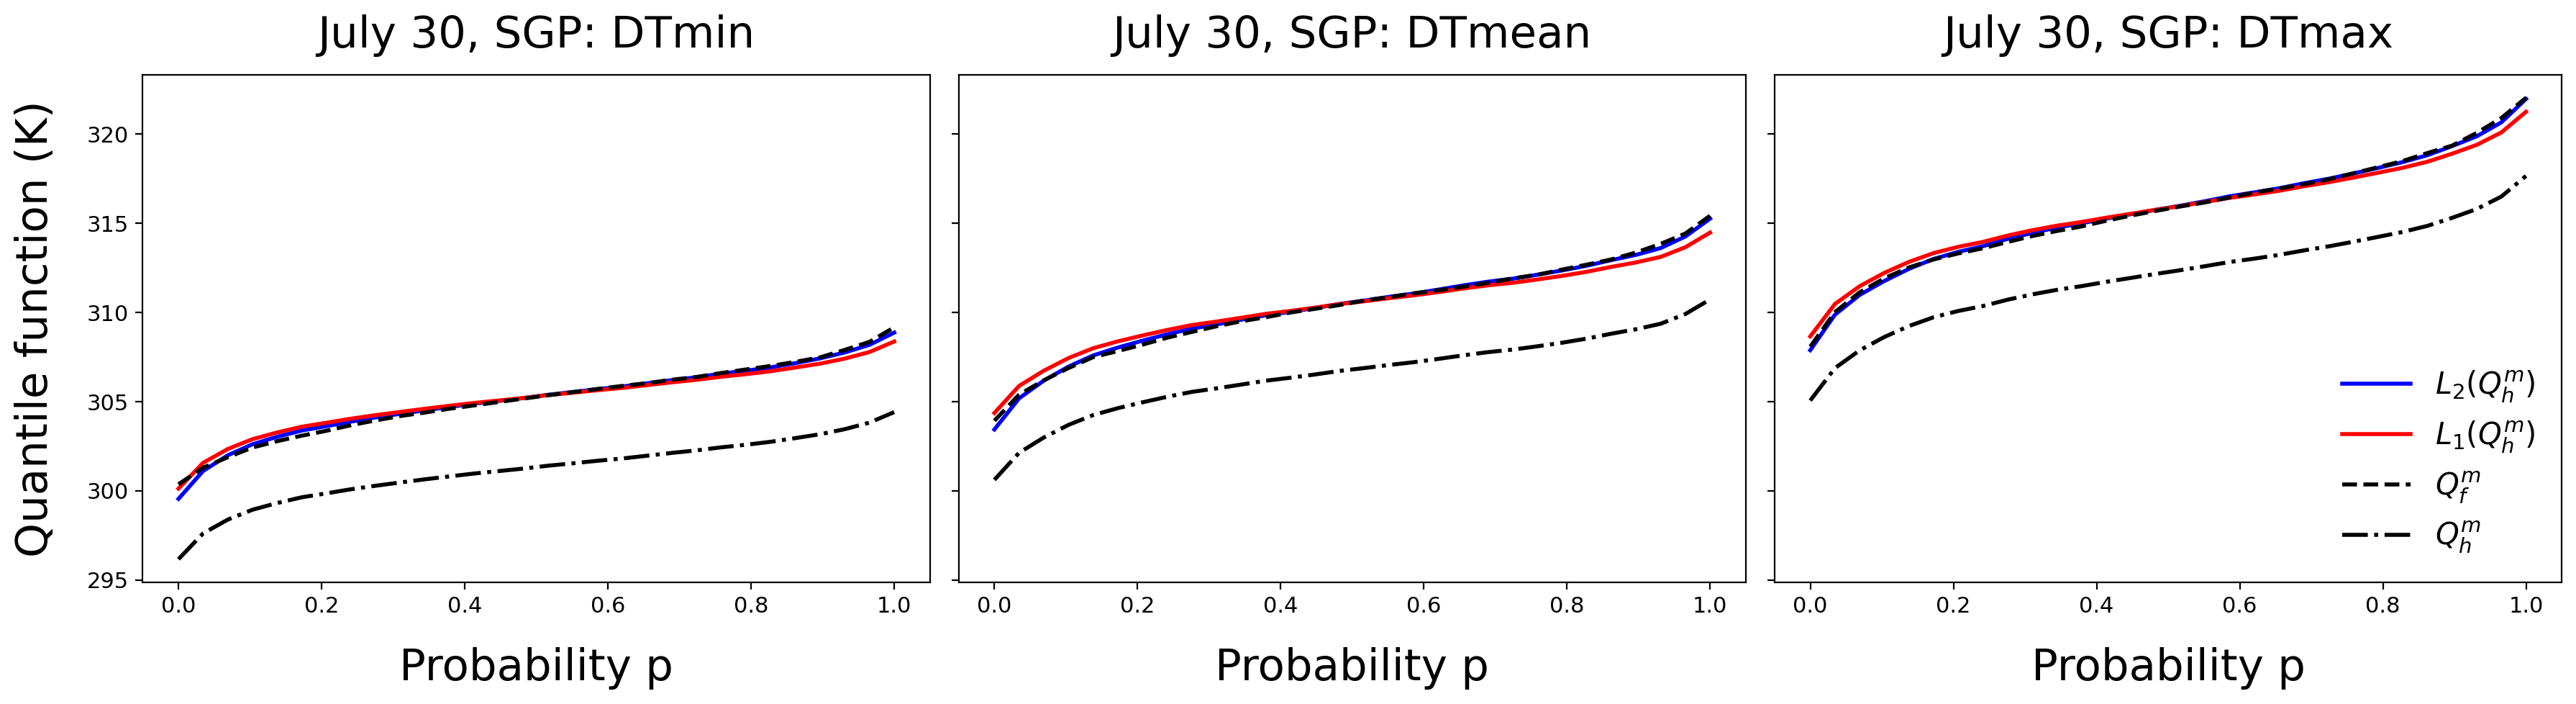

CPU times: user 869 ms, sys: 24.8 ms, total: 894 ms
Wall time: 1.29 s


In [133]:
%%time
import matplotlib.pyplot as plt

# Define mapping of variable names to their data arrays
variables = {
    'DTmin': {
        'L2': qsgp_mdm_emean_tmin,
        'L1': qsgp_shift_emean_tmin,
        'Forecast': qsgp_eoc_emean_tmin,
        'Historical': qsgp_pi_emean_tmin
    },
    'DTmean': {
        'L2': qsgp_mdm_emean_tmean,
        'L1': qsgp_shift_emean_tmean,
        'Forecast': qsgp_eoc_emean_tmean,
        'Historical': qsgp_pi_emean_tmean
    },
    'DTmax': {
        'L2': qsgp_mdm_emean_tmax,
        'L1': qsgp_shift_emean_tmax,
        'Forecast': qsgp_eoc_emean_tmax,
        'Historical': qsgp_pi_emean_tmax
    }
}

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (var_name, data) in zip(axs, variables.items()):
    ax.plot(quants, data['L2'], color='blue', label=r'$L_2(Q_h^m)$', lw=2)
    ax.plot(quants, data['L1'], color='red', label=r'$L_1(Q_h^m)$', lw=2)
    ax.plot(quants, data['Forecast'], 'k--', label=r'$Q_f^m$', lw=2)
    ax.plot(quants, data['Historical'], 'k-.', label=r'$Q_h^m$', lw=2)

    ax.set_title(f'July 30, SGP: {var_name}', fontweight=300, fontsize=22, y=1.03)
    ax.set_xlabel('Probability p', fontweight=300, fontsize=22, labelpad=15)
    ax.tick_params(axis='both', labelsize=11)

    if ax is axs[0]:
        ax.set_ylabel('Quantile function (K)', fontweight=300, fontsize=22, labelpad=15)


# Add legend to the last subplot
axs[-1].legend(loc='lower right', prop={'size': 15}, frameon=False, handlelength=2.29)
plt.savefig("fig2.pdf", format="pdf", bbox_inches="tight",dpi=600)
plt.tight_layout()
plt.show()

In [131]:
# cluster.close()